# Experiment 1 Baseline

Checking whether an array is a heap using an RNN or LSTM

In [1]:
%cd ..
%pwd
import wandb
from experiments.heaps import *
from experiments.utils import *
from baselines.baseline_rnn import *
from baselines.baseline_lstm import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/tekne/Oxford/ATML/Project/ggs-nn-model


In [2]:
PROJECT_NAME="rnn_heap_check"

In [3]:
def get_data(config):
    data = make_heap_test_rnn_datapoints(
        n = config["n_train"] + config["n_test"],
        p_heap = config["p_heap"],
        min_len = config["min_len"],
        max_len = config["max_len"],
    )

    training_data = DataLoader(data[:config["n_train"]], batch_size=config["batch_size"])
    testing_data = DataLoader(data[config["n_train"]:], batch_size=config["batch_size"])

    return training_data, testing_data

def make_lstm(config):
    return BaselineLSTM(
        input_size=1,
        output_size=2,
        hidden_size=config["hidden_size"]
    ).cuda()

def make_rnn(config):
    return BaselineRNN(
        input_size=1,
        output_size=2,
        hidden_size=config["hidden_size"]
    ).cuda()

def make_model(config):
    model = config.get("model", "rnn")
    if model == "lstm":
        return make_lstm(config)
    elif model == "rnn":
        return make_rnn(config)
    else:
        raise ValueError(f"config[\"model\"] == {model}")

In [4]:
def run_model(config, logger=wandb):
    NUM_CLASSES = 2

    model = make_model(config)
    if logger is not None:
        logger.watch(model)
        logger.run.summary["model_parameters"] = model.count_parameters()

    opt = torch.optim.Adam(model.parameters(), lr=config["lr"])
    loss = torch.nn.CrossEntropyLoss()

    training_data, testing_data = get_data(config)

    results = train(
        model=lambda batch : model(batch[0].cuda()),
        opt=opt,
        training_data=training_data,
        testing_data=testing_data,
        criterion=lambda out, batch: loss(out[0].view(-1, 2), batch[1].flatten().cuda()),
        checker=lambda out, batch: (int((torch.argmax(out[0].view((-1, 2)), dim=-1) == batch[1].flatten().cuda()).sum()), batch[1].shape[0]),
        epochs=config["epochs"],
        logger=logger
    )

    plt.plot(results["train_loss"], label="Training loss")
    plt.plot(results["test_loss"], label="Testing loss")
    plt.legend()
    plt.show()

    plt.plot(results["train_accuracy"], label="Training accuracy")
    plt.plot(results["test_accuracy"], label="Testing accuracy")
    plt.legend()
    plt.show()

def evaluate_model(config, **kwargs):
    wandb.init(**kwargs)
    wandb.config = config

    run_model(wandb.config)

    wandb.finish()

In [5]:
config = {
    "model": "rnn",
    "n_train": 1000,
    "n_test": 1000,
    "epochs": 300,
    "lr": 0.01,
    "opimizer": "adam",
    "min_len": 1,
    "max_len": 64,
    "batch_size": 500,
    "p_heap": 0.5,
    "hidden_size": 10,
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tekne (use `wandb login --relogin` to force relogin)
/home/tekne/.local/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


  0%|          | 0/300 [00:00<?, ?it/s]/home/tekne/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 300/300 [00:15<00:00, 19.31it/s]


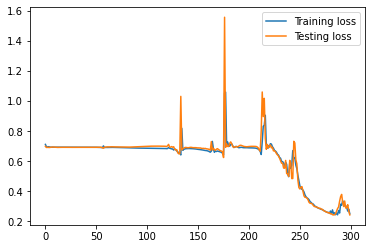

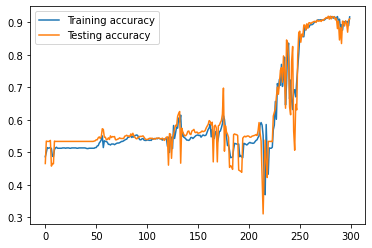

model_parameters,142
train_loss,0.25034
train_accuracy,0.917
_runtime,37
_timestamp,1617965086
_step,599
test_loss,0.243
test_accuracy,0.911


train_loss,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆█▆▆▅▆▃▂▂▁▁▂▁
train_accuracy,▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▄▂▂▃▃▁▃▄▆▄▇██████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▅▅▅▅█▅▅▄▃▃▂▁▁▁▂▁
test_accuracy,▂▁▂▂▂▂▂▃▂▂▂▃▃▂▂▂▃▄▃▃▃▃▃▅▁▁▃▃▁▂▄▅▇▇████▇█


In [6]:
evaluate_model(config, project=PROJECT_NAME)

In [7]:
sweep_config = {
    "name": "Bayesian sweep",
    "method": "bayes",
    "metric": {
        "name": "test_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {
            "distribution": "constant",
            "value": 500
        },
        "model": {
            "distribution": "categorical",
            "values": ["rnn", "lstm"]
        },
        "n_train": {
            "distribution": "int_uniform",
            "min": 50,
            "max": 5000,
        },
        "n_test": {
            "distribution": "constant",
            "value": 1000
        },
        "lr": {
            "distribution": "normal",
            "mu": 0.01,
            "sigma": 0.002
        },
        "optimizer": {
            "distribution": "constant",
            "value": "adam"
        },
        "min_len": {
            "distribution": "constant",
            "value": 1
        },
        "max_len": {
            "distribution": "int_uniform",
            "min": 32,
            "max": 128
        },
        "batch_size": {
            "distribution": "constant",
            "value": 500
        },
        "p_heap": {
            "distribution": "uniform",
            "min": 0.4,
            "max": 0.6
        },
        "hidden_size": {
            "distribution": "int_uniform",
            "min": 0,
            "max": 50
        },
    },
    "project": "rnn_heap_check"
}

In [8]:
sweep_id = wandb.sweep(sweep_config, project="rnn_heap_check")

Create sweep with ID: y6pvw243
Sweep URL: https://wandb.ai/tekne/rnn_heap_check/sweeps/y6pvw243


In [9]:
def run_sweep():
    run = wandb.init()
    run_model(run.config, logger=wandb)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: egf4n8c6 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 12
wandb: 	lr: 0.011966178954360992
wandb: 	max_len: 86
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 2816
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5743933710888924
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:07<00:00,  7.35it/s]


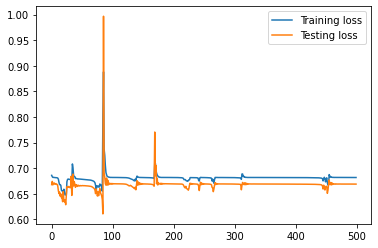

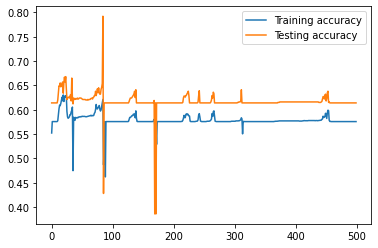

model_parameters,194
train_loss,0.68177
train_accuracy,0.57564
_runtime,68
_timestamp,1617965231
_step,999
test_loss,0.66888
test_accuracy,0.614


train_loss,▇▁▆▆▆▅▂█▇▇▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_accuracy,▁█▂▃▃▃▆▁▁▁▂▂▁▁▁▁▁▃▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▁▆▆▇▆▅▇██▆▇█▇███▅█▇█▇███▇█████████▆▇███
test_accuracy,▁█▃▃▂▂▅▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁


wandb: Agent Starting Run: 6k3njzqh with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 36
wandb: 	lr: 0.006896913456596245
wandb: 	max_len: 70
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 4476
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5645129795223311
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/500 [00:00<?, ?it/s]/home/tekne/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
100%|██████████| 500/500 [00:28<00:00, 17.75it/s]


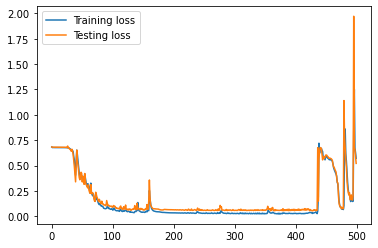

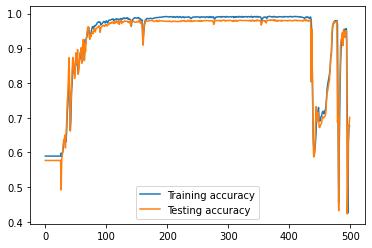

model_parameters,792
train_loss,0.57089
train_accuracy,0.67627
_runtime,29
_timestamp,1617965264
_step,999
test_loss,0.52113
test_accuracy,0.701


train_loss,▇▇▇▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆▂▅█
train_accuracy,▁▁▁▅▆▇▇████████████████████████████▃▃▇▄▃
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▁▃█
test_accuracy,▃▃▃▇▆▇█████████████████████████████▅▅█▆▁


wandb: Agent Starting Run: nuetdaab with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 24
wandb: 	lr: 0.01121703768958436
wandb: 	max_len: 91
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 831
wandb: 	optimizer: adam
wandb: 	p_heap: 0.49132113428943053
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:36<00:00, 13.83it/s]


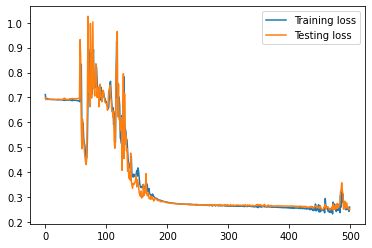

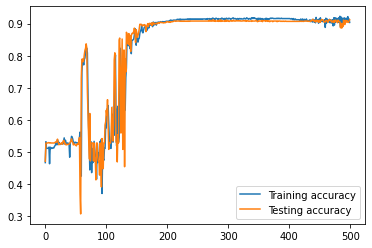

model_parameters,674
train_loss,0.26026
train_accuracy,0.90373
_runtime,37
_timestamp,1617965306
_step,999
test_loss,0.25036
test_accuracy,0.912


train_loss,▆▆▆▆▆▄█▆▅▄▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
train_accuracy,▂▂▂▂▂▆▁▁▄▆▄▆▇▇██████████████████████▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▇▇▇▇▇▅█▇▇▅▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▂▂▂▂▂▆▁▁▃▅▂▇████████████████████████████


wandb: Agent Starting Run: 54e5e99q with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 36
wandb: 	lr: 0.011241673352425992
wandb: 	max_len: 45
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 3421
wandb: 	optimizer: adam
wandb: 	p_heap: 0.4357888350417585
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:45<00:00, 10.92it/s]


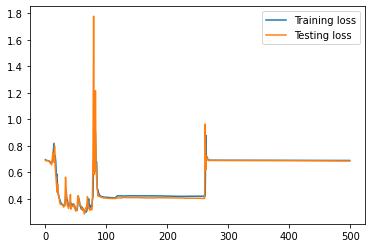

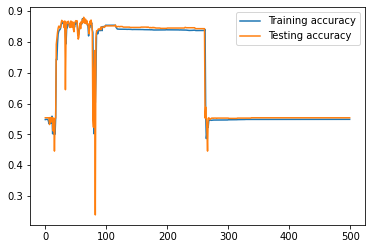

model_parameters,1442
train_loss,0.68863
train_accuracy,0.54896
_runtime,46
_timestamp,1617965358
_step,999
test_loss,0.68468
test_accuracy,0.554


train_loss,▇█▂▂▁▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃███████████▇▇▇▇▇▇▇▇
train_accuracy,▂▁████▃▇██▇▇▇▇▇▇▇▇▇▇▇▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▃▃▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
test_accuracy,▃▁████▂▇██▇▇▇▇▇▇▇▇▇▇▇▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃


wandb: Agent Starting Run: idlfgtqs with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 18
wandb: 	lr: 0.008600744424294423
wandb: 	max_len: 121
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 509
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5656254027409854
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:13<00:00, 38.43it/s]


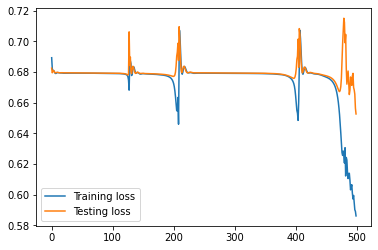

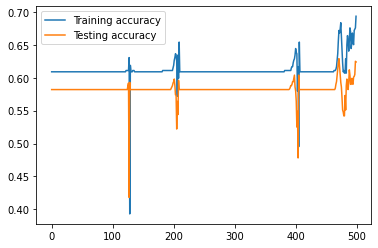

model_parameters,396
train_loss,0.58605
train_accuracy,0.69352
_runtime,14
_timestamp,1617965377
_step,999
test_loss,0.65265
test_accuracy,0.624


train_loss,▆▆▆▆▆▆▆▆▆▆▅▆▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█▆▆▆▆▅▃▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁█▁▆
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▃▃▃▃▃▃▃▃▃▃█▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▃▃▃▃▁▄▁
test_accuracy,▆▆▆▆▆▆▆▆▆▆▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆█▇▇


wandb: Agent Starting Run: uszayw8r with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 15
wandb: 	lr: 0.009054791366370404
wandb: 	max_len: 73
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 4765
wandb: 	optimizer: adam
wandb: 	p_heap: 0.4744248272532174
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:30<00:00,  5.54it/s]


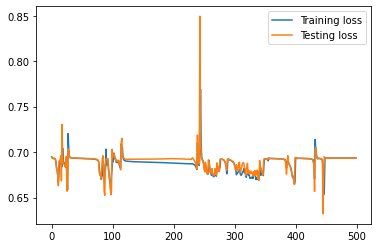

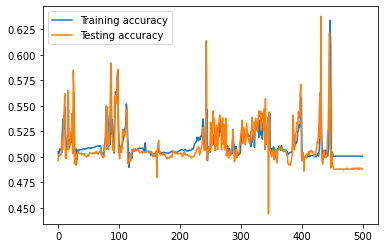

model_parameters,287
train_loss,0.69347
train_accuracy,0.50073
_runtime,91
_timestamp,1617965473
_step,999
test_loss,0.69328
test_accuracy,0.488


train_loss,▅▄█▅▅▅▃▅▅▇▅▅▄▄▄▄▄▄▄▅▃▃▅▅▃▃▃▃▅▅▅▃▅▅▅▁▅▅▅▅
train_accuracy,▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▂▂▂▂▂▃▁▁▂▃▃▃▂▂▁▃▁▁▁█▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▂▂▂▂▂▂▁▂▂▃▂▂▂▂▂▂▂▂▂█▁▁▂▂▂▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂
test_accuracy,▂▂▁▂▂▂▄▂▂▁▂▂▂▂▂▂▂▂▂█▄▄▂▂▂▃▄▃▁▂▂▄▂▂▂▁▁▁▁▁


wandb: Agent Starting Run: 051m683n with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 8
wandb: 	lr: 0.012427519442614492
wandb: 	max_len: 90
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 2472
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5243627126407986
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


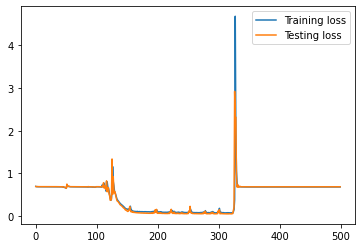

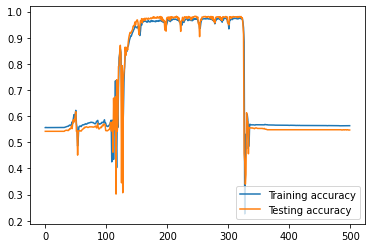

model_parameters,98
train_loss,0.68197
train_accuracy,0.56351
_runtime,65
_timestamp,1617965544
_step,999
test_loss,0.68716
test_accuracy,0.547


train_loss,▇▇▇▇▇▇▇▇▇▆█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_accuracy,▁▁▁▁▂▂▂▂▁▄▁▇▇█████████████▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▆▆▆▆▇▆▆▆▆▆█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆
test_accuracy,▃▃▃▄▃▄▄▄▃▅▁▇██████████████▄▄▄▄▄▄▄▄▄▄▄▄▄▄


wandb: Agent Starting Run: ncvos96h with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 28
wandb: 	lr: 0.010534340443759858
wandb: 	max_len: 102
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 1109
wandb: 	optimizer: adam
wandb: 	p_heap: 0.4719914348873445
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:15<00:00, 31.89it/s]


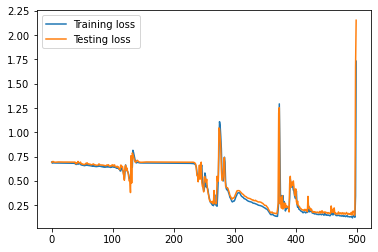

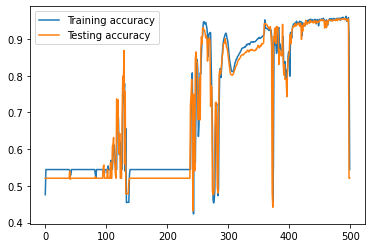

model_parameters,616
train_loss,1.73244
train_accuracy,0.54463
_runtime,16
_timestamp,1617965565
_step,999
test_loss,2.15316
test_accuracy,0.521


train_loss,███████▇▇▇▆████████▇▅▄▇▃▄▃▃▂▁▂▂▅▂▁▁▁▂▁▁▁
train_accuracy,▃▃▃▃▃▃▃▃▃▃▅▃▃▃▃▃▃▃▃▁▆▇▄▇▆▇▇▇▇▇█▆████████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,██████▇▇▇▇▅████████▆▄▃▅▃▄▃▃▃▁▂▂▅▂▁▁▁▂▁▁▁
test_accuracy,▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▅▇▇▄▇▆▆▇▇█▇▆▅████████


wandb: Agent Starting Run: 5bbw6osc with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 26
wandb: 	lr: 0.012249636585979062
wandb: 	max_len: 93
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 832
wandb: 	optimizer: adam
wandb: 	p_heap: 0.4771107443587519
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:11<00:00, 41.84it/s]


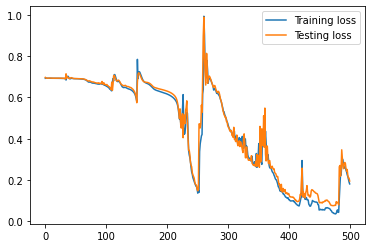

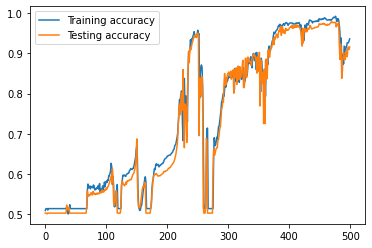

model_parameters,572
train_loss,0.18128
train_accuracy,0.9363
_runtime,12
_timestamp,1617965583
_step,999
test_loss,0.19503
test_accuracy,0.916


train_loss,██████▇▇▇█▇▇█▇▇▇▇▆▆▃▅▇▇▆▅▅▄▄▅▃▂▂▂▂▁▁▁▁▂▃
train_accuracy,▁▁▁▁▁▁▂▂▂▁▂▂▁▁▃▃▃▄▅▇▆▁▃▆▆▆▆▆▅▇█████████▇
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,███████▇▇█▇▇██▇▇▇▆▆▃▅█▇▆▅▄▄▃▄▃▂▂▁▂▂▂▁▁▃▃
test_accuracy,▁▁▁▁▁▁▂▂▂▂▂▂▁▁▂▂▃▅▅▇▆▁▃▆▆▆▆▇▆▇████████▇▇


wandb: Agent Starting Run: mruax6gb with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 48
wandb: 	lr: 0.010739295566874404
wandb: 	max_len: 34
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 223
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5940990169300779
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:12<00:00, 39.98it/s]


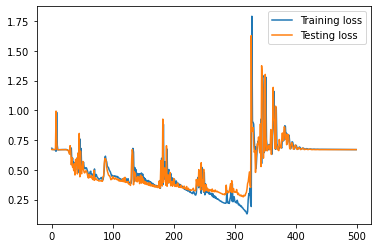

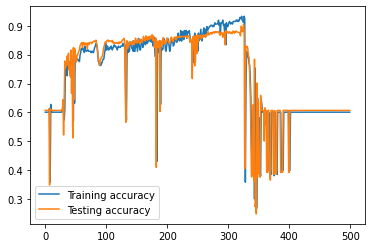

model_parameters,2498
train_loss,0.67003
train_accuracy,0.6009
_runtime,13
_timestamp,1617965601
_step,999
test_loss,0.66986
test_accuracy,0.607


train_loss,▆▆▆▄▄▄▄▄▄▃▃▄▃▃▃▄▃▃▂▃▃▂▂▂▂▁██▆▆▇▆▆▆▆▆▆▆▆▆
train_accuracy,▄▄▄▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇██████▇▁▄▄▄▄▄▄▄▄▄▄▄▄
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▆▆▆▅▅▃▃▄▃▂▂▃▂▂▅▃▂▂▂▂▁▁▁▃▁▁▆▄█▆▇▆▆▆▆▆▆▆▆▆
test_accuracy,▃▃▃▆▆▇▇▆▇▇▇▇▇▇▇▇▇██▇███▇██▇▆▁▃▃▃▃▃▃▃▃▃▃▃


wandb: Agent Starting Run: nsa2l1if with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 14
wandb: 	lr: 0.01030773676410033
wandb: 	max_len: 125
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 1257
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5397082532878519
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:16<00:00, 29.94it/s]


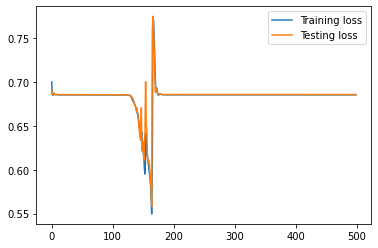

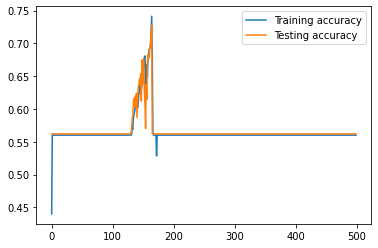

model_parameters,308
train_loss,0.68517
train_accuracy,0.56006
_runtime,17
_timestamp,1617965624
_step,999
test_loss,0.6855
test_accuracy,0.562


train_loss,▃▃▃▃▃▃▃▃▃▃▃▂▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▃▃▃▃▃▃▃▃▃▃▃▂▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: d5uxel9g with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 42
wandb: 	lr: 0.0086303538496706
wandb: 	max_len: 91
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 2694
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5617503862139205
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


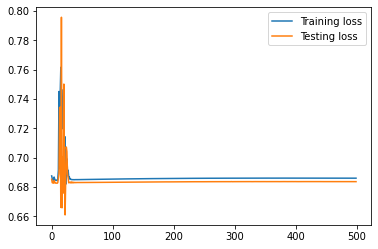

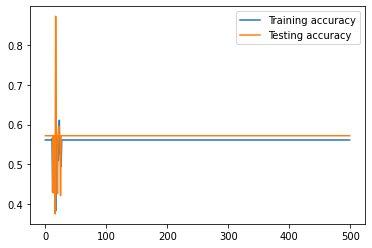

model_parameters,1934
train_loss,0.68596
train_accuracy,0.56125
_runtime,76
_timestamp,1617965705
_step,999
test_loss,0.6836
test_accuracy,0.572


train_loss,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,█▁██████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▇▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: dj7hwqi4 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 39
wandb: 	lr: 0.009126957102199233
wandb: 	max_len: 106
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 2184
wandb: 	optimizer: adam
wandb: 	p_heap: 0.42593936034407925
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


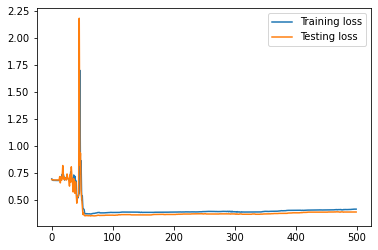

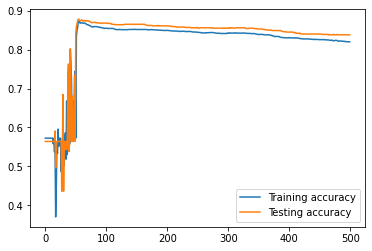

model_parameters,1679
train_loss,0.41489
train_accuracy,0.82005
_runtime,76
_timestamp,1617965786
_step,999
test_loss,0.38837
test_accuracy,0.838


train_loss,███▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
train_accuracy,▂▁▁▄▇███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▇██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
test_accuracy,▃▃▁▃█████████████████████████████▇▇▇▇▇▇▇


wandb: Agent Starting Run: 259bkc8h with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 17
wandb: 	lr: 0.01025396746382816
wandb: 	max_len: 93
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 4475
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5412013793978028
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


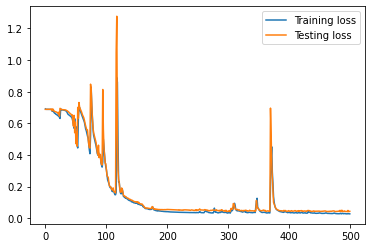

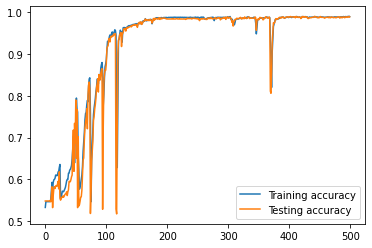

model_parameters,374
train_loss,0.02746
train_accuracy,0.9895
_runtime,32
_timestamp,1617965823
_step,999
test_loss,0.04347
test_accuracy,0.989


train_loss,████▆▇▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▁▂▅▃▄▆▇▇▇██████████████████▅██████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,████▆▇▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▂▁▂▃▃▄▆▇▇▇██████████████████▆██████████


wandb: Agent Starting Run: vuw15a9d with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 10
wandb: 	lr: 0.007536977120567589
wandb: 	max_len: 75
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 4006
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5533571005994102
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:25<00:00,  5.88it/s]


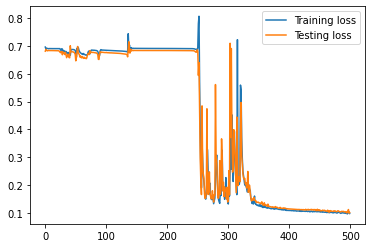

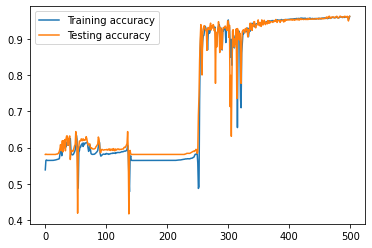

model_parameters,142
train_loss,0.09841
train_accuracy,0.96131
_runtime,86
_timestamp,1617965914
_step,999
test_loss,0.10189
test_accuracy,0.962


train_loss,████████████████████▃▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇█▇▇▇█████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,████████████████████▂▂▇▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▅█▇▇▇█████████████


wandb: Agent Starting Run: f7eu8geo with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 9
wandb: 	lr: 0.010561975507184039
wandb: 	max_len: 96
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 3100
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5788595343190582
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:24<00:00, 20.03it/s]


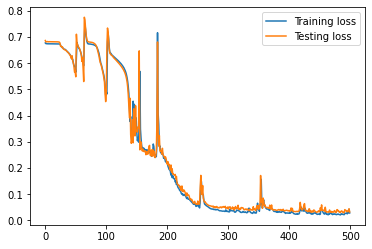

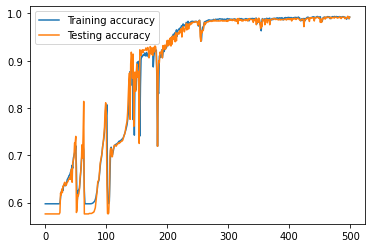

model_parameters,198
train_loss,0.0287
train_accuracy,0.99226
_runtime,26
_timestamp,1617965945
_step,999
test_loss,0.03248
test_accuracy,0.992


train_loss,██▇▇▇▇█▇█▇▇▅▇▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▂▂▃▁▃▁▃▃▆▄▇▇▇▇███▇███████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,██▇▇█▆█▇█▇▇▅▃▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▂▂▁▅▁▃▁▃▄▄▇▇▇▇▇▇██▇███████████████████


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 0xvzlslm with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 20
wandb: 	lr: 0.01072988540007333
wandb: 	max_len: 56
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 2567
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5305328154282974
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:48<00:00, 10.33it/s]


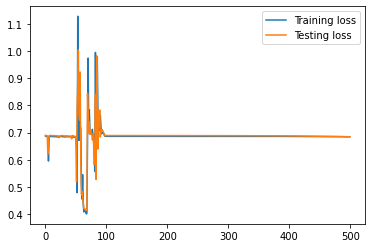

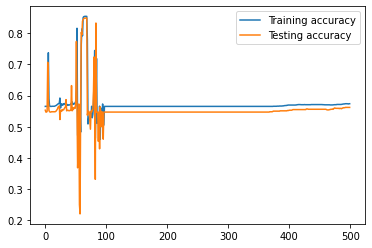

model_parameters,482
train_loss,0.68415
train_accuracy,0.57382
_runtime,49
_timestamp,1617966037
_step,999
test_loss,0.68436
test_accuracy,0.562


train_loss,▇▇▇▇▆▁▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_accuracy,▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▇▇▇▇▃▁▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
test_accuracy,▁▁▁▁▆█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: kksp8599 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 8
wandb: 	lr: 0.011369880739017218
wandb: 	max_len: 66
wandb: 	min_len: 1
wandb: 	model: rnn
wandb: 	n_test: 1000
wandb: 	n_train: 3152
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5494498865619395
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [01:02<00:00,  7.97it/s]


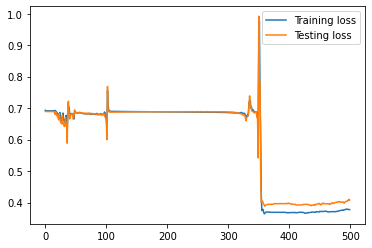

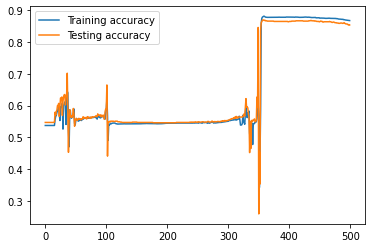

model_parameters,98
train_loss,0.37767
train_accuracy,0.8677
_runtime,64
_timestamp,1617966106
_step,999
test_loss,0.40814
test_accuracy,0.854


train_loss,██▇██▇▇▇█████████████████▇▇█▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▂▂▃▁▂▃▃▃▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,██▇█████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁████████████


wandb: Agent Starting Run: ibjy7rhy with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 24
wandb: 	lr: 0.008919150524569874
wandb: 	max_len: 86
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 4474
wandb: 	optimizer: adam
wandb: 	p_heap: 0.576745037751455
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:31<00:00, 16.02it/s]


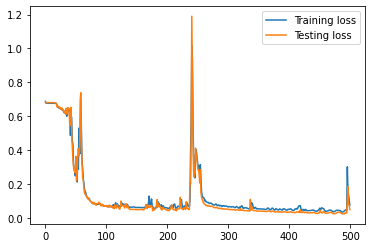

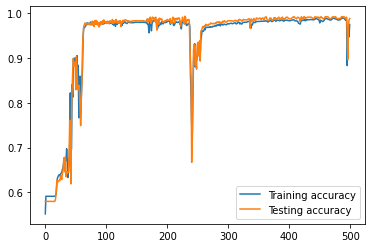

model_parameters,528
train_loss,0.07414
train_accuracy,0.97452
_runtime,32
_timestamp,1617966145
_step,999
test_loss,0.04874
test_accuracy,0.988


train_loss,████▄▃▂▁▁▂▁▁▁▁▁▁▁▁▁▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄
train_accuracy,▁▁▂▂▆██████████████▆▇██████████████████▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,███▇▃▃▂▁▁▁▂▁▁▁▁▁▁▁▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
test_accuracy,▁▁▂▃▆██████████████▇▇██████████████████▇


wandb: Agent Starting Run: ifb9afj6 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 27
wandb: 	lr: 0.008824446629253453
wandb: 	max_len: 40
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 4129
wandb: 	optimizer: adam
wandb: 	p_heap: 0.4228710253021706
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:20<00:00, 23.98it/s]


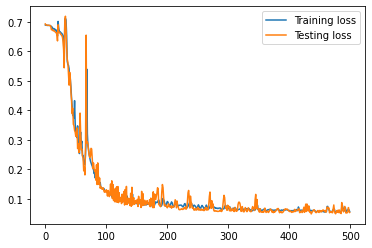

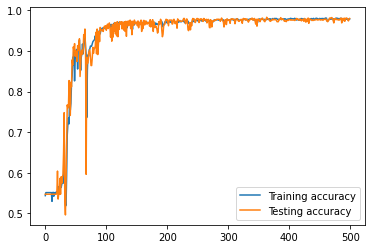

model_parameters,594
train_loss,0.057
train_accuracy,0.97869
_runtime,21
_timestamp,1617966172
_step,999
test_loss,0.05407
test_accuracy,0.98


train_loss,███▆▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▄▇▇▇█████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,███▆▄▃▃▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▁▆▇▇▇██▇██████████████████████████████


wandb: Agent Starting Run: r18bzitr with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 36
wandb: 	lr: 0.014530668176656224
wandb: 	max_len: 56
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 54
wandb: 	optimizer: adam
wandb: 	p_heap: 0.41991436249327285
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 500/500 [00:06<00:00, 77.02it/s]


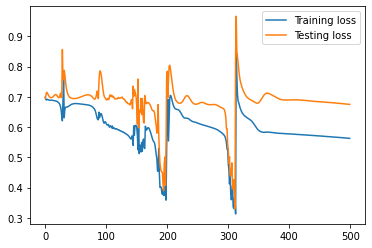

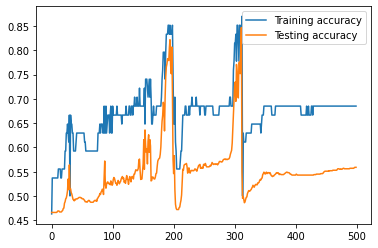

model_parameters,792
train_loss,0.56264
train_accuracy,0.68519
_runtime,7
_timestamp,1617966186
_step,999
test_loss,0.67497
test_accuracy,0.559


train_loss,██▇███▇▇▆▆▆▅▅▆▅▁▇▇▇▆▆▆▆▅▁▇▇▆▆▆▅▅▅▅▅▅▅▅▅▅
train_accuracy,▁▁▃▂▃▂▃▃▄▃▄▄▆▄▄█▃▄▄▄▄▄▄▄▆▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▇▆▆▆▆▆▆█▆▆▆▆▅▆▅▂█▆▆▆▆▆▆▅▁▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆
test_accuracy,▁▁▃▂▂▁▂▂▃▃▃▃▄▃▄█▁▃▃▃▃▃▃▄█▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃


wandb: Agent Starting Run: f0ukpah0 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 2
wandb: 	lr: 0.0073113568274964374
wandb: 	max_len: 46
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 2569
wandb: 	optimizer: adam
wandb: 	p_heap: 0.4959720224371123
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run f0ukpah0 errored: ValueError('proj_size has to be smaller than hidden_size')
wandb: ERROR Run f0ukpah0 errored: ValueError('proj_size has to be smaller than hidden_size')
wandb: Agent Starting Run: 3yzs14ah with config:
wandb: 	batch_size: 500
wandb: 	epochs: 500
wandb: 	hidden_size: 45
wandb: 	lr: 0.01118209478838443
wandb: 	max_len: 99
wandb: 	min_len: 1
wandb: 	model: lstm
wandb: 	n_test: 1000
wandb: 	n_train: 500
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5022494967129342
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 66%|██████▌   | 329/500 [01:39<16:55,  5.94s/it]

In [10]:
wandb.agent(sweep_id, function=run_sweep, project="rnn_heap_check")